In [ ]:
import pandas as pd
import pickle
import os
import numpy as np
# data = pickle.load(open('../data/leftppgecg.p','rb'))
directory = '../data_users/ecg_ppg/'
dfs = []
for f in os.listdir(directory)[:10]:
    if f[-1]!='p':
        continue
    a = pickle.load(open(directory+f,'rb'))
    print(a.shape,end=',')
    dfs.append(a)
print()
data1 = pd.concat(dfs)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy
data_all = data1

data_all['red_rr'] = data_all['ppg_rr'].apply(lambda x:x[0])
data_all['ir_rr'] = data_all['ppg_rr'].apply(lambda x:x[1])
data_all['green_rr'] = data_all['ppg_rr'].apply(lambda x:x[2])
data_all['red_qual'] = data_all['likelihood'].apply(lambda x:x[0])
data_all['ir_qual'] = data_all['likelihood'].apply(lambda x:x[1])
data_all['green_qual'] = data_all['likelihood'].apply(lambda x:x[2])
data_all['index'] = data_all['likelihood'].apply(lambda x:np.argmax(np.array(x)))
values = data_all[['ppg_rr','index']].values
values = [a[b] for a,b in values]
data_all['ppg_rr_best'] = values
data_all['likelihood_best'] = data_all['likelihood'].apply(lambda x:max(x))

In [ ]:
import pickle
pickle.dump(data_all,open('../data_users/merged_data.p','wb'),protocol=4)

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
data_all = pickle.load(open('../data_users/merged_data.p','rb'))

In [29]:
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel,delayed
from hrvanalysis import get_time_domain_features

from copy import deepcopy

def get_data1(a):
    features = []
    ecg_rr = a[:,-1]
    if len(ecg_rr[np.isnan(ecg_rr)])>40:
        return [],[],[],[],[],[]
    m = np.mean(ecg_rr[ecg_rr>0])
    s = np.std(ecg_rr[ecg_rr>0])
    ecg_rr[np.isnan(ecg_rr)] = 0
    if len(ecg_rr)<60:
        return [],[],[],[],[],[]
    y = []
    X = []
    ecg = []
    means = []
    stds = []
    quals = []
    for i in [-2]:
        ppg_rr = a[:,i]
        ppg_qual = a[:,i-4]
#         index = ppg_rr>0
#         ppg_qual = ppg_qual[index]
#         ppg_rr = ppg_rr[index]
        index = np.isnan(ppg_rr)
        index1 = ~np.isnan(ppg_rr)
        if len(ppg_rr[index1])<10:
            continue
        ppg_qual[index] = -1
        ppg_rr[index] = np.nanmean(ppg_rr)
        tmp = a[:,np.array([-2,-3,-4,-5,-6,-7,-8,-9,1])].reshape(60,9)
        tmp[np.isnan(tmp[:,0]),0] = np.nanmean(tmp[~np.isnan(tmp[:,0]),0])
        tmp[tmp[:,0]==0,0] = np.median(tmp[tmp[:,0]>0,0])
        y.append(tmp[:,0].reshape(1,60,1))
        X.append(tmp.reshape(1,60,9))
        means.append(m)
        stds.append(s)
        ecg.append(ecg_rr.reshape(1,60,1))
        quals.append(ppg_qual.reshape(1,60,1))
#         for j in np.linspace(0,.9,20):
#             index = ppg_qual>j
#             ppg_qual = ppg_qual[index]
#             ppg_rr = ppg_rr[index]
#             if len(ppg_rr)<10:
#                 continue
#             f = list(get_time_domain_features(ppg_rr).values())
#             f1 = list(get_time_domain_features(ecg_rr).values())
#             q = [np.percentile(ppg_qual,20),np.median(ppg_qual),len(ppg_rr)/60]
#             features.append(np.array(f1+f+q))
    return X,y,ecg,means,stds,quals

unique_users = data_all['user'].unique()

def get_data(name,df):
    df = df[['time','activity','red_qual','ir_qual','green_qual','likelihood_best',
             'red_rr','ir_rr','green_rr','ppg_rr_best','ecg_rr']].values
    return df.reshape(-1,60,11)
all_X = []

def get_all_data(data_user):
    data_user.set_index('timestamp',inplace=True)
    convert_dict = {'ecg_rr': float}
    data_user = data_user.astype(convert_dict) 
    data_resampled = data_user.resample('1S').mean()
    if 'ecg_rr' not in np.array(data_resampled.columns.values):
        return []
    df_col = [get_data(group_name, df_group) for group_name, df_group
                                           in data_resampled.groupby(pd.Grouper(freq='60S')) if df_group.shape[0]==60]
    df_user = np.concatenate(df_col)
    df_col = [get_data1(a) for a in df_user if len(a[~np.isnan(a[:,-1]),-1])>20]
    return df_col
# for user in unique_users:
#     data_user = data_all[data_all.user.isin([user])]
all_X = Parallel(n_jobs=20,verbose=3)(delayed(get_all_data)(data_all[data_all.user.isin([user])]) for user in unique_users)

[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  10 | elapsed:   20.4s remaining:   47.6s
[Parallel(n_jobs=20)]: Done   7 out of  10 | elapsed:  1.1min remaining:   27.9s
[Parallel(n_jobs=20)]: Done  10 out of  10 | elapsed:  1.4min finished


In [30]:
X,y,ecg,means,stds,quals = [],[],[],[],[],[]
for i,b in enumerate(all_X):
    if len(b)==0:
        continue
    for a in b:
        X.extend(a[0])
        y.extend(a[1])
        ecg.extend(a[2])
        means.extend(a[3])
        stds.extend(a[4])
        quals.extend(a[5])

In [31]:
import pickle
pickle.dump([X,y,ecg,means,stds,quals],open('../data_users/processed_data.p','wb'),protocol=4)

In [80]:
import pandas as pd
import pickle
import os
import numpy as np
X,y,ecg,means,stds,quals = pickle.load(open('../data_users/processed_data.p','rb'))

In [81]:
np.concatenate(X).shape

(14283, 60, 9)

In [82]:
X,y,ecg,means,stds,quals = np.concatenate(X),np.concatenate(y).reshape(-1,60),np.concatenate(ecg).reshape(-1,60),\
np.array(means).reshape(-1,1),np.array(stds).reshape(-1,1),np.concatenate(quals)

In [83]:
from keras.layers import Input, LSTM, RepeatVector,Bidirectional,Multiply,multiply,Permute
from keras.layers import TimeDistributed,Dense,Flatten,Reshape,Lambda,Activation,GRU
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import numpy as np
import keras.backend as K
from keras import metrics,losses
import tensorflow as tf
import tensorflow_probability as tfp
X_train, X_test, y_train, y_test,ecg_train, \
ecg_test,means_train,means_test,stds_train,stds_test, \
quals_train,quals_test= train_test_split(
    X[:,:,np.array([0,4])], y,ecg,means,stds,quals, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val,means_train,means_val,stds_train,stds_val = train_test_split(
    X_train, y_train,means_train,stds_train, test_size=0.2, random_state=42)
print(X_train.shape,y_train.shape,y_val.shape,means_val.shape,stds_val.shape)

(7655, 60, 2) (7655, 60) (1914, 60) (1914, 1) (1914, 1)


In [122]:
def output_of_lambda(input_shape):
    return (input_shape[0], 1)

def mean(x):
    return K.mean(x, axis=1, keepdims=True)

def output_of_lambda1(input_shape):
    return (input_shape[0], 1)

def mean1(x):
    return K.std(x, axis=1, keepdims=True)

timesteps = 60
input_dim = 2
latent_dim = 20
output_dim = 1
n = 1
inputs = Input(shape=(timesteps, input_dim))
# inputs2 = Reshape((1,1))(inputs1)
encoded = Bidirectional(GRU(60,return_sequences=True,activation='relu',go_backwards=True))(inputs)
# encoded = LSTM(output_dim,return_sequences=True,activation='sigmoid')(encoded)
att = Dense(1,activation='relu')(encoded)

att = Flatten()(att)
att = Activation(activation="softmax")(att)
att = Reshape((timesteps,))(att)
att = RepeatVector(120)(att)
att = Permute((2,1))(att)
mer = multiply([att, encoded])

encoded = TimeDistributed(Dense(10,activation='relu'))(mer)
encoded = Flatten()(encoded)
encoded = Dense(10,activation='relu',name='sequence1')(encoded)
encoded = Dense(60,activation='relu',name='sequence')(encoded)
# encoded = Reshape((60),name='sequence')(encoded)
# encoded_std = K.std(encoded,axis=1)
decoded = Lambda(mean, output_shape=output_of_lambda,name='mean')(encoded)
decoded1 = Lambda(mean1, output_shape=output_of_lambda1,name='std')(encoded)
# decoded = LSTM(output_dim*60, return_sequences=True)(decoded)
# decoded = LSTM(output_dim*3, return_sequences=True)(decoded)
# decoded = LSTM(output_dim, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs=inputs, outputs=encoded)
# encoder = Model(inputs, encoded)
losses = {
    "sequence": "logcosh"
}
lossWeights = {"sequence": 1}
# initialize the optimizer and compile the model

sequence_autoencoder.compile(optimizer='adam',loss=losses, loss_weights=lossWeights)

sequence_autoencoder.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 60, 2)        0                                            
__________________________________________________________________________________________________
bidirectional_23 (Bidirectional (None, 60, 120)      22680       input_47[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 60, 1)        121         bidirectional_23[0][0]           
__________________________________________________________________________________________________
flatten_24 (Flatten)            (None, 60)           0           dense_10[0][0]                   
___________________________________________________________________________________________

In [123]:
filepath = '../models/base_LSTM.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=30)
callbacks_list = [es,checkpoint]
history = sequence_autoencoder.fit(X_train, y_train,
                epochs=100,
                batch_size=500,
                shuffle=True,
                validation_data=(X_val,y_val),callbacks=callbacks_list)

Train on 7655 samples, validate on 1914 samples
Epoch 1/100
7655/7655 [==============================] - 4s 471us/step - loss: 765.9671 - val_loss: 761.9035

Epoch 00001: val_loss improved from inf to 761.90354, saving model to ../models/base_LSTM.hdf5
Epoch 2/100
7655/7655 [==============================] - 3s 344us/step - loss: 755.1844 - val_loss: 740.3046

Epoch 00002: val_loss improved from 761.90354 to 740.30462, saving model to ../models/base_LSTM.hdf5
Epoch 3/100
7655/7655 [==============================] - 3s 343us/step - loss: 711.5006 - val_loss: 652.5720

Epoch 00003: val_loss improved from 740.30462 to 652.57195, saving model to ../models/base_LSTM.hdf5
Epoch 4/100
7655/7655 [==============================] - 3s 345us/step - loss: 538.6308 - val_loss: 367.4208

Epoch 00004: val_loss improved from 652.57195 to 367.42083, saving model to ../models/base_LSTM.hdf5
Epoch 5/100
7655/7655 [==============================] - 3s 374us/step - loss: 332.9710 - val_loss: 288.5567

Epoc

7655/7655 [==============================] - 5s 604us/step - loss: 186.3364 - val_loss: 183.1802

Epoch 00041: val_loss did not improve from 175.32929
Epoch 42/100
7655/7655 [==============================] - 5s 633us/step - loss: 181.7518 - val_loss: 176.6975

Epoch 00042: val_loss did not improve from 175.32929
Epoch 43/100
7655/7655 [==============================] - 5s 602us/step - loss: 179.7468 - val_loss: 176.4553

Epoch 00043: val_loss did not improve from 175.32929
Epoch 44/100
7655/7655 [==============================] - 5s 601us/step - loss: 179.1593 - val_loss: 175.7894

Epoch 00044: val_loss did not improve from 175.32929
Epoch 45/100
7655/7655 [==============================] - 5s 602us/step - loss: 178.7064 - val_loss: 175.3865

Epoch 00045: val_loss did not improve from 175.32929
Epoch 46/100
7655/7655 [==============================] - 5s 603us/step - loss: 178.3585 - val_loss: 174.9756

Epoch 00046: val_loss improved from 175.32929 to 174.97564, saving model to ../mod

7655/7655 [==============================] - 9s 1ms/step - loss: 175.3400 - val_loss: 171.4506

Epoch 00086: val_loss did not improve from 170.78951
Epoch 87/100
7655/7655 [==============================] - 10s 1ms/step - loss: 174.1415 - val_loss: 170.7863

Epoch 00087: val_loss improved from 170.78951 to 170.78628, saving model to ../models/base_LSTM.hdf5
Epoch 88/100
7655/7655 [==============================] - 9s 1ms/step - loss: 173.4392 - val_loss: 170.3889

Epoch 00088: val_loss improved from 170.78628 to 170.38889, saving model to ../models/base_LSTM.hdf5
Epoch 89/100
7655/7655 [==============================] - 9s 1ms/step - loss: 173.4371 - val_loss: 171.7193

Epoch 00089: val_loss did not improve from 170.38889
Epoch 90/100
7655/7655 [==============================] - 9s 1ms/step - loss: 173.9605 - val_loss: 170.7353

Epoch 00090: val_loss did not improve from 170.38889
Epoch 91/100
7655/7655 [==============================] - 9s 1ms/step - loss: 173.4377 - val_loss: 170.181

In [124]:
from keras.models import load_model
sequence_autoencoder = load_model(filepath)

In [125]:
y_pred1 = sequence_autoencoder.predict(X_test)
y_pred = y_pred1
# [0]
# mean_pred = y_pred1[1]
# stds_pred = y_pred1[2]

In [126]:
y_pred1[0].shape,y_pred1[1].shape,y_pred1[2].shape

((60,), (60,), (60,))

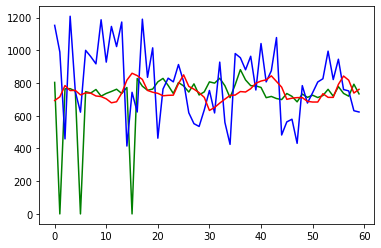

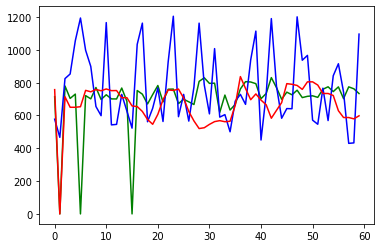

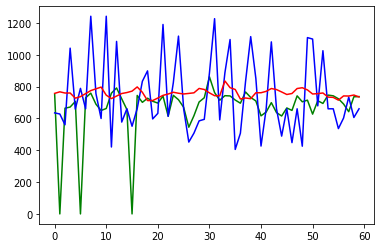

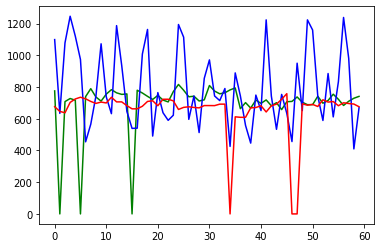

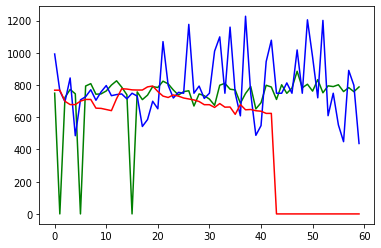

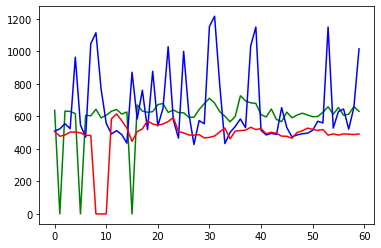

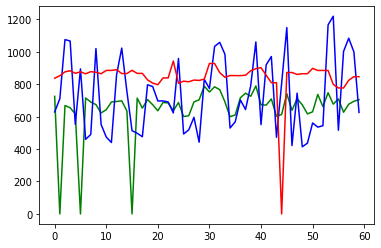

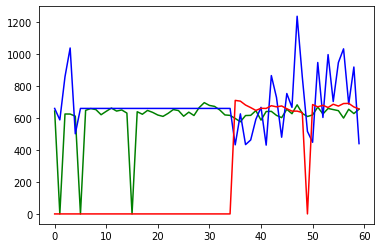

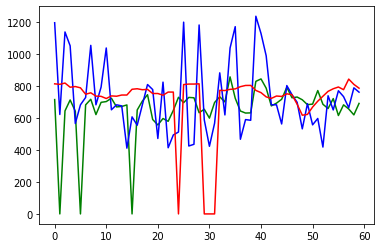

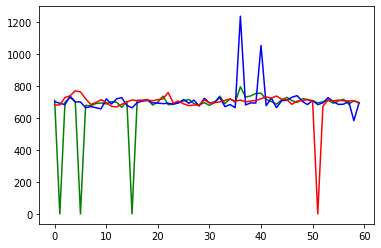

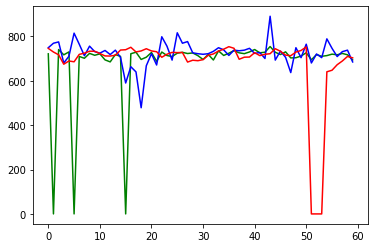

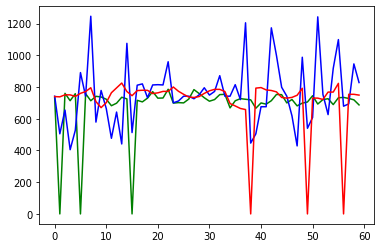

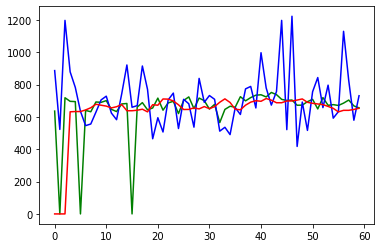

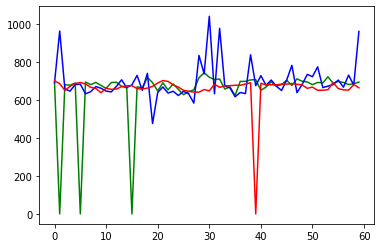

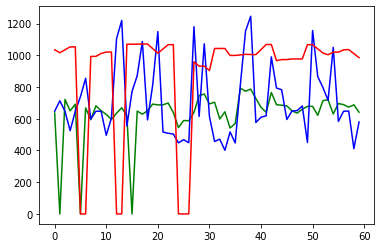

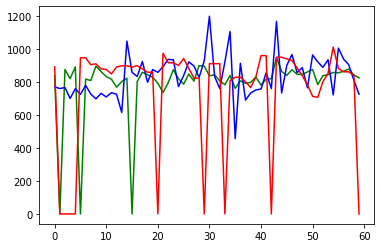

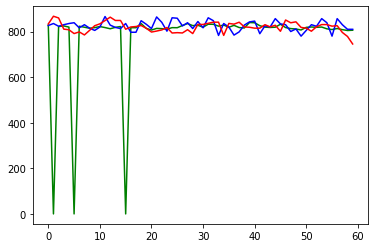

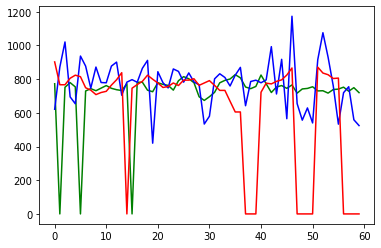

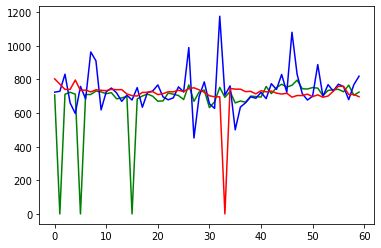

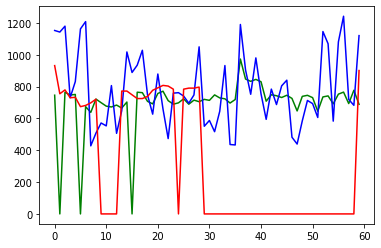

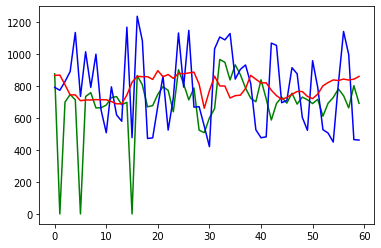

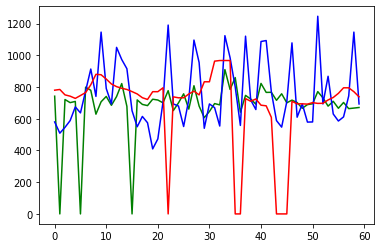

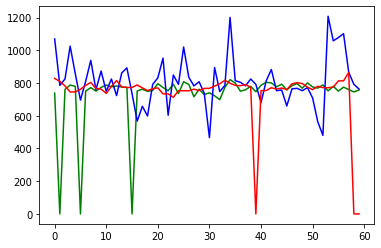

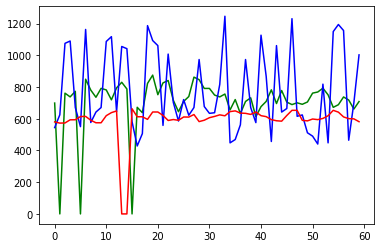

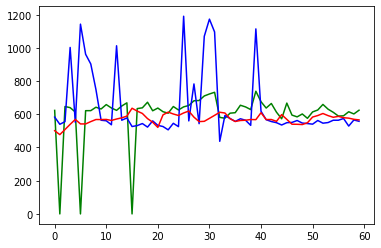

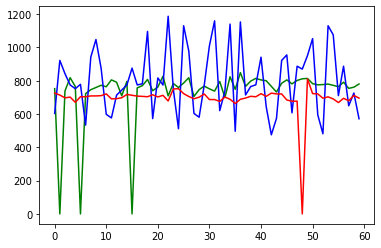

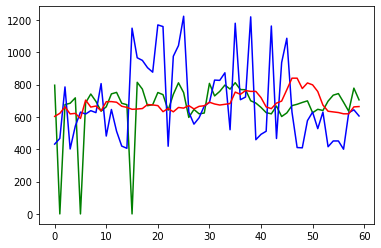

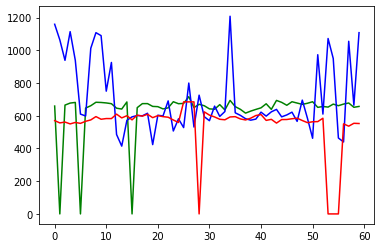

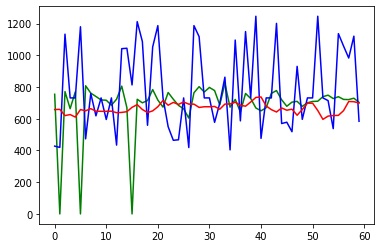

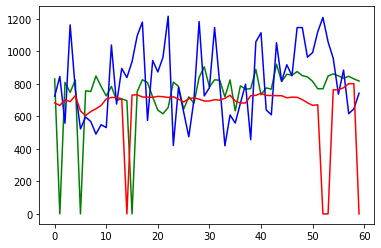

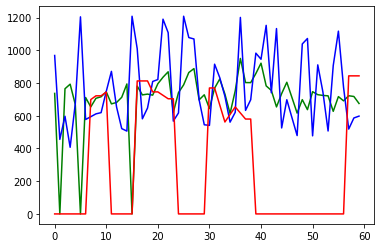

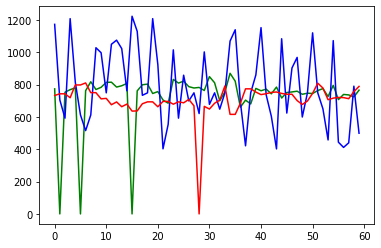

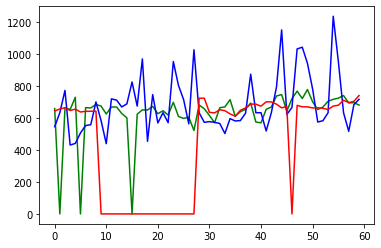

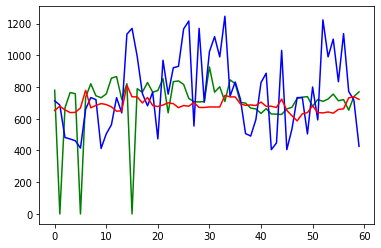

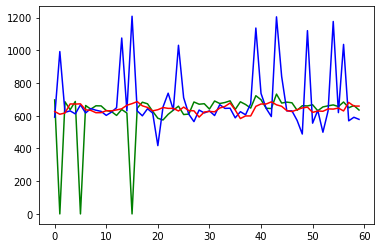

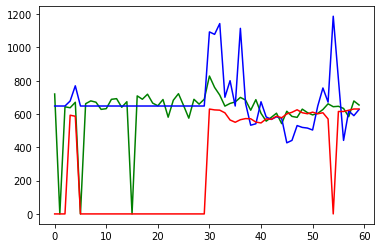

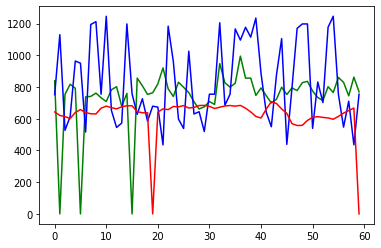

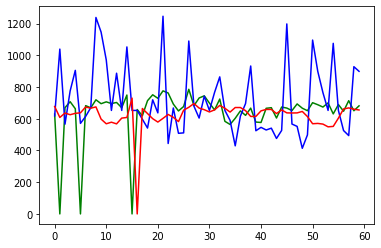

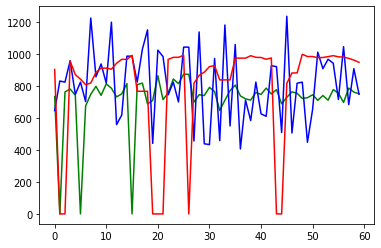

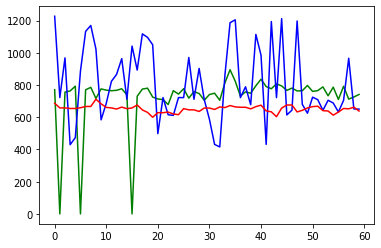

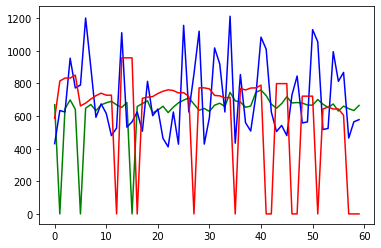

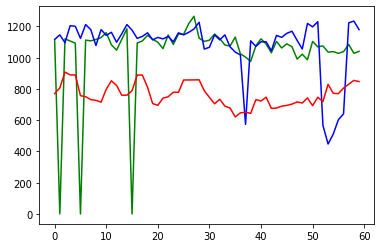

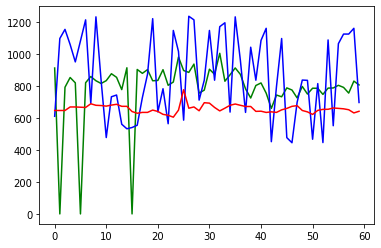

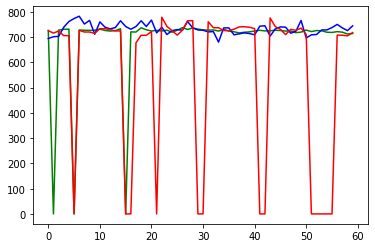

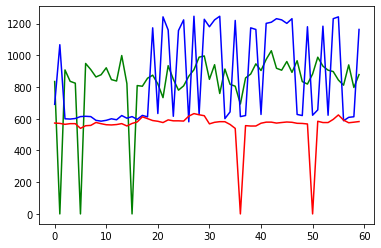

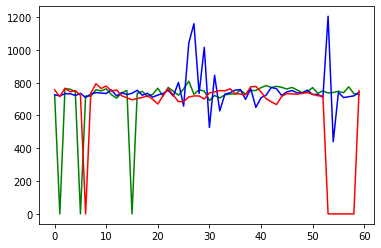

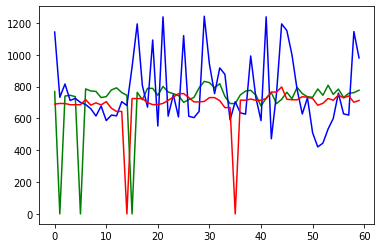

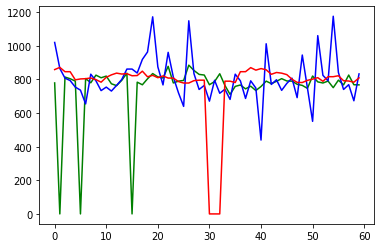

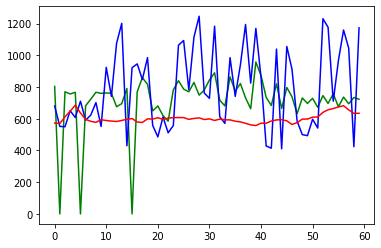

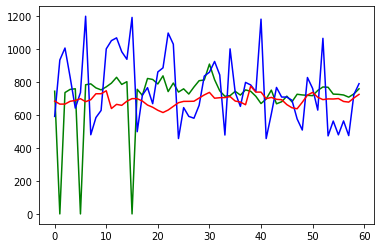

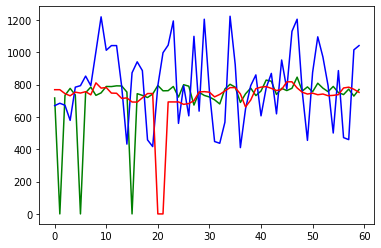

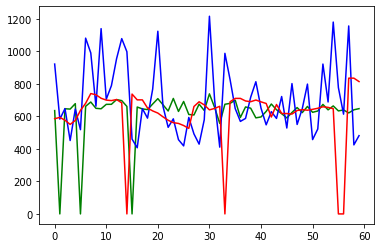

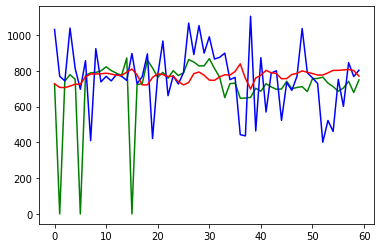

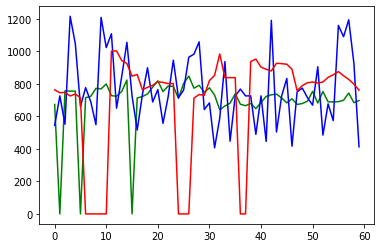

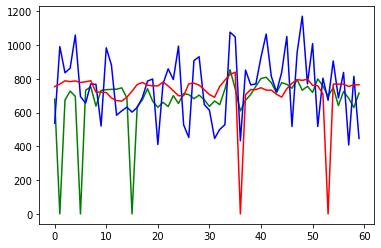

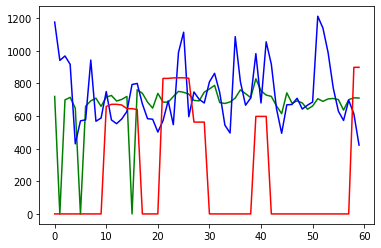

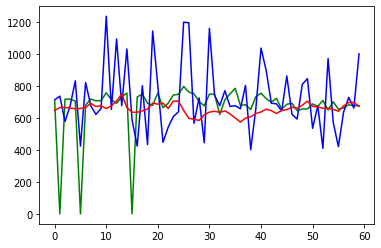

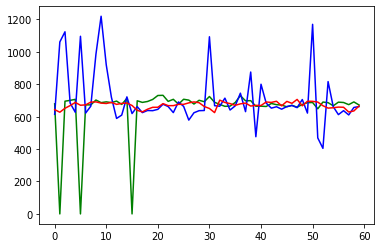

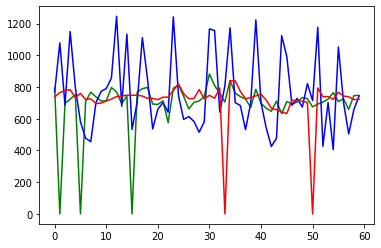

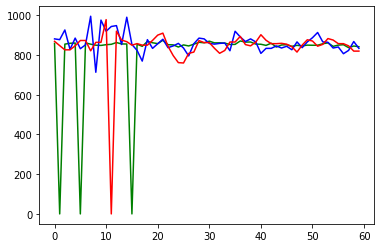

In [127]:
%matplotlib  inline
import matplotlib.pyplot as plt
# plt.plot(y[-10])
for i,a in enumerate(y_pred[:60]):
#     if np.sum(a)>0:
    plt.figure()
    plt.plot(a,'g')
#     plt.plot(X_test[i,:,:4],'r')
    plt.plot(y_test[i],'b')
    plt.plot(ecg_test[i],'r')
    plt.show()

In [128]:
X = np.zeros((len(quals_test.reshape(-1)),4))
X[:,0] = quals_test.reshape(-1)
X[:,1] = y_pred.reshape(-1)
X[:,2] = ecg_test.reshape(-1)
X[:,3] = y_test.reshape(-1)

In [129]:
X = X[X[:,0]>-1]
X = X[X[:,1]>0]
X = X[X[:,2]>0]
X = X[X[:,3]>0]


(array([1.43000e+02, 1.19720e+04, 1.23867e+05, 9.33990e+04, 1.31460e+04,
        1.37700e+03, 2.42000e+02, 2.60000e+01, 4.00000e+00, 1.00000e+00]),
 array([ 416.1234436 ,  526.55958557,  636.99572754,  747.43186951,
         857.86801147,  968.30415344, 1078.74029541, 1189.17643738,
        1299.61257935, 1410.04872131, 1520.48486328]),
 <a list of 10 Patch objects>)

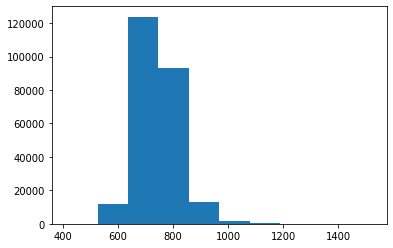

In [130]:
plt.hist(X[:,1])

20 20


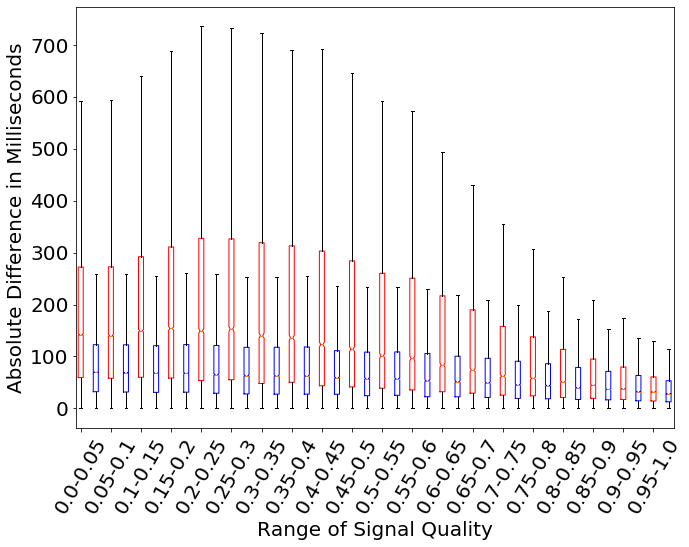

In [131]:
l_range = np.arange(0,1,.05)
x = []
y = []
y1 = []
for l in l_range:
    index = np.where((X[:,0]>=l)&(X[:,0]<l+.05))[0]
    temp = X[index]
#     print(temp.shape,l)
    x.append(str(np.round(l*100)/100)+'-'+str(np.round((l+.05)*100)/100))
    y.append(list(np.abs(temp[:,2]-temp[:,3])))
    a = np.array(np.abs(temp[:,1]-temp[:,2]))
    y1.append(a[~np.isnan(a)])
print(len(y),len(y1))
#     print(np.mean(np.abs(temp[:,0]-temp[:,2])),np.std(np.abs(temp[:,0]-temp[:,2])),len(index))
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size':20})
c = plt.boxplot(y,showfliers=False,positions=np.array(range(0,3*len(y),3)),notch=True)
for box in c['boxes']:
    box.set(color='red', linewidth=1)
b = plt.boxplot(y1,showfliers=False,positions=np.array(range(0,3*len(y),3))+1.5,notch=True)
for box in b['boxes']:
    box.set(color='blue', linewidth=1)
#     box.set(facecolor = 'red' )
plt.xticks(np.array(range(0,3*len(y),3)),x,rotation=60)
plt.ylabel('Absolute Difference in Milliseconds')
plt.xlabel('Range of Signal Quality')
plt.tight_layout()
plt.show()   

In [132]:
from hrvanalysis import get_time_domain_features
x = []
y = []
z = []
q = []
s = 'mean_hr'
for i in range(ecg_test.shape[0]):
    qual_min = quals_test[i].reshape(-1)
    qual_min = qual_min[qual_min>-1]
    ecg_min = ecg_test[i].reshape(-1)
    ecg_min = ecg_min[ecg_min>0]
    ecg_min= ecg_min[~np.isnan(ecg_min)]
    y_pred_min = y_pred[i].reshape(-1)
    y_pred_min = y_pred_min[~np.isnan(y_pred_min)]
    y_test_min = y_test[i].reshape(-1)
    y_test_min = y_test_min[y_test_min>0]
    y_test_min = y_test_min[~np.isnan(y_test_min)]
    if len(ecg_min)<10 or len(y_pred_min)<5 or len(y_test_min)<5:
        continue
    x.append(get_time_domain_features(y_pred_min)[s])
    y.append(get_time_domain_features(ecg_min)[s])
    z.append(get_time_domain_features(y_test_min)[s])
    q.append(np.median(qual_min))
    if np.isinf(x[-1]) or np.isinf(y[-1]) or np.isinf(z[-1]) or np.isinf(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
    elif np.isnan(x[-1]) or np.isnan(y[-1]) or np.isnan(z[-1]) or np.isnan(q[-1]):
        x = x[:-1]
        y= y[:-1]
        z= z[:-1]
        q= q[:-1]
#     print(np.std(ecg_min),np.std(y_test_min),np.std(y_pred_min),np.median(qual_min))
    
    

In [133]:
from scipy.stats import pearsonr,spearmanr
q,x,y,z = np.array(q),np.array(x),np.array(y),np.array(z)
for i in np.linspace(0,.9,10):
    index = np.where((q>=i)&(q<=i+.1))[0]
    if len(index)<2:
        continue
    print(pearsonr(x[index],y[index]),pearsonr(y[index],z[index]),i,i+.1,len(index))

In [ ]:
# plt.hist(y.reshape(-1),50)
plt.hist(y_pred.reshape(-1),50)
plt.hist(y_test.reshape(-1)+300,50)
plt.hist(ecg_test.reshape(-1)+600,50)

In [ ]:
np.std(y[0].reshape(1,-1,1),axis=1)

In [ ]:
plt.plot(y_pred1[1].reshape(-1),means_test.reshape(-1),'*')

In [ ]:
from scipy.stats import pearsonr
pearsonr(y_pred1[1].reshape(-1),means_test.reshape(-1))

In [ ]:
import keras

In [ ]:
keras.__version__

In [ ]:
y_pred.reshape(-1).shape

In [ ]:
t = y_pred.reshape(-1)

In [ ]:
t[np.isfinite(t)].shape

In [ ]:
plt.hist(quals_test.reshape(-1))